In [1]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilterClass2D(object):
    
    def __init__(self, dt, a_x, a_y, sd_acceleration, x_sd, y_sd):
        
        self.dt = dt

        # the acceleration which is essentially u from the state update equation 
        self.a = np.matrix([[a_x],[a_y]])

        

        #  The state transition matrix 
        self.A = np.matrix([[1, 0, self.dt, 0],[0, 1, 0, self.dt],[0, 0, 1, 0],[0, 0, 0, 1]])

        # The control input transition matrix 
        self.B = np.matrix([[(self.dt**2)/2, 0],[0,(self.dt**2)/2],[self.dt,0],[0,self.dt]])

        # The matrix that maps state vector to measurement 
        self.H = np.matrix([[1, 0, 0, 0],[0, 1, 0, 0]])

        # Processs Covariance that for our case depends solely on the acceleration  
        self.Q = np.matrix([[(self.dt**4)/4, 0, (self.dt**3)/2, 0],[0, (self.dt**4)/4, 0, (self.dt**3)/2],
                            [(self.dt**3)/2, 0, self.dt**2, 0],[0, (self.dt**3)/2, 0, self.dt**2]]) * sd_acceleration**2

        # Measurement Covariance
        self.R = np.matrix([[x_sd**2,0],
                           [0, y_sd**2]])

        # The error covariance matrix that is Identity for now. It gets updated based on Q, A and R.
        self.P = np.eye(self.A.shape[1])
        
        #  Finally the vector in consideration ; it's [ x position ;  y position ; x velocity ; y velocity ; ]
        self.x = np.matrix([[0], [0], [0], [0]])

    def predict(self):

        # The state update : X_t = A*X_t-1 + B*u 
        # here u is acceleration,a 
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.a)
        
        # Updation of the error covariance matrix 
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        return self.x[0:2]

    def update(self, z):


        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R

 
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S)) 
    
        self.x = np.round(self.x + np.dot(K, (z - np.dot(self.H, self.x))))  

        I = np.eye(self.H.shape[1])

        self.P = (I -(K*self.H))*self.P  
        
        return self.x[0:2]

In [2]:
import os
os.sys.path
import numpy as np
import cv2

def calc_centroid(image,thresh):
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        centroids = []
        blob_thresh = 4
        for i in contours:
            try:
                (x, y), r = cv2.minEnclosingCircle(i)
                centeroid = (int(x), int(y))
                r = int(r)
                if (r > blob_thresh):
                    cv2.circle(image, centeroid, r, (0, 0, 255), 2)
                    coords = np.array([[x], [y]])
                    centroids.append(np.round(coords))
            except ZeroDivisionError:
                pass
        return centroids

class Detect(object):
    def __init__(self):
        self.bgd = cv2.createBackgroundSubtractorMOG2()

    def get_centroid(self, image):
        g = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        try:
            cv2.imshow('Gray Scaled', g)
        except:
            print("End")

        f = self.bgd.apply(g)
        e = cv2.Canny(f, 50, 190, 3)
        _, thresh = cv2.threshold(e, 127, 255, 0)
        return calc_centroid(image, thresh)

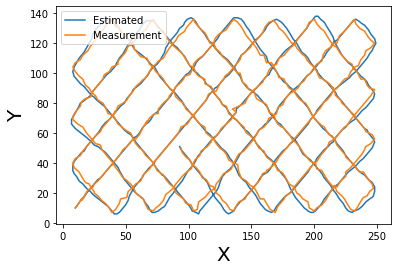

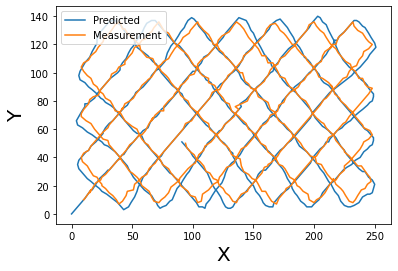

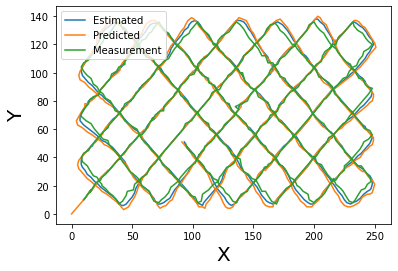

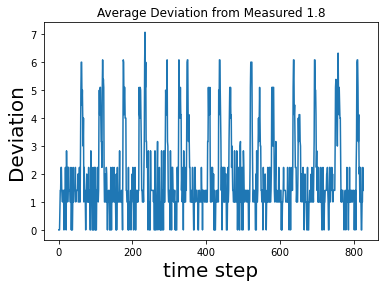

In [3]:

def main():
    
    
    # dt, a_x, a_y, sd_acceleration, x_sd, y_sd
    KF = KalmanFilterClass2D(0.1, 1, 1, 1, 0.1,0.1)

    Video = cv2.VideoCapture('ball4.mp4')
    
    detection = Detect()
    
    E=[]
    t=[]
    G=[[] , [] , [] , [], [], []]
    X=[[]]
    i=0
    
    writer=None
    
    while(True):
        
        ret, frame = Video.read()
        if not ret:
            break
        
        centers = detection.get_centroid(frame)
        
        (x, y) = KF.predict()
        X.append([x,y])
        
        if (len(centers) > 0):
            
            
            cv2.circle(frame, (int(centers[0][0]), int(centers[0][1])), 10, (0, 191, 255), 2)
            
            
            x,y=int(x),int(y)
            G[4].append(x)
            G[5].append(y)
     
            (x1, y1) = KF.update(centers[0])
            
            
            x1=int(x1)
            y1=int(y1)
            G[0].append(x1)
            G[1].append(y1)
            x,y=int(x),int(y)
            
            G[2].append(int(centers[0][0]))
            G[3].append(int(centers[0][1]))
            E.append(((int(centers[0][0])-x1)**2 + (int(centers[0][1])-y1)**2)**0.5)
            t.append(i)
            cv2.rectangle(frame, (x1 - 14, y1 - 14), (x1 + 14, y1 + 14), (255, 0, 0), 2)
            cv2.putText(frame, "Estimated Position", (x1 + 14, y1 + 9), 0, 0.5, (0, 100, 255), 2)

            cv2.putText(frame, "Measured Position", (int(centers[0][0]) + 15, int(centers[0][1]) - 15), 0, 0.5, (0,255,100), 2)
        if i>3:
            cv2.line(frame, (int(X[i][0]), int(X[i][1])), (int(X[i-3][0]), int(X[i-3][1])),(0,0,255), 2)
        i+=1
        
        cv2.imshow('image', frame)
        
        if writer is None:
            writer = cv2.VideoWriter('./output6.avi', cv2.VideoWriter_fourcc(*"MJPG") , 30, (frame.shape[1], frame.shape[0]), True)
        writer.write(frame)
        
        cv2.waitKey(70)
    Video.release()
    cv2.destroyAllWindows()
  
    plt.plot(G[0],G[1],label='Estimated')
    plt.plot(G[2],G[3],label='Measurement')
    
    plt.xlabel('X', fontsize=20)
    plt.ylabel('Y', fontsize=20)
    plt.legend()
    plt.show()
    
    plt.plot(G[4],G[5],label='Predicted')
    plt.plot(G[2],G[3],label='Measurement')
    
    plt.xlabel('X', fontsize=20)
    plt.ylabel('Y', fontsize=20)
    plt.legend()
    plt.show()
    
    plt.plot(G[0],G[1],label='Estimated')
    plt.plot(G[4],G[5],label='Predicted')
    plt.plot(G[2],G[3],label='Measurement')
    
    plt.xlabel('X', fontsize=20)
    plt.ylabel('Y', fontsize=20)
    plt.legend()
    plt.show()
    
    plt.plot(t,E)
    S= str(sum(E)/len(E))
    plt.title("Average Deviation from Measured "+ S[:3])
    plt.ylabel('Deviation', fontsize=20)
    plt.xlabel('time step', fontsize=20)
    plt.show()
    
if __name__ == "__main__":
    main()

In [4]:
class Hungarian(object):

    def __init__(self, arr_costs):
        self.X = arr_costs.copy()

        n, m = self.X.shape
        self.u_row = np.ones(n, dtype=bool)
        self.u_column = np.ones(m, dtype=bool)
        self.r_0Z = 0
        self.c_0Z = 0
        self.course = np.zeros((n + m, 2), dtype=int)
        self.check = np.zeros((n, m), dtype=int)

    def clear(self):
        self.u_row[:] = True
        self.u_column[:] = True
        
   #step 1 of hungarian algorithm     
def row_reduction(assignment):
    assignment.X -= assignment.X.min(axis=1)[:, np.newaxis]
    for i, j in zip(*np.where(assignment.X == 0)):
        if assignment.u_column[j] and assignment.u_row[i]:
            assignment.check[i, j] = 1
            assignment.u_column[j] = False
            assignment.u_row[i] = False

    assignment.clear()
    return cover_columns
#step 2 of hungarian algorithm 
def cover_columns(assignment):
    check = (assignment.check == 1)
    assignment.u_column[np.any(check, axis=0)] = False

    if check.sum() < assignment.X.shape[0]:
        return cover_zeros
#step 3 of hungarian algorithm   
def cover_zeros(assignment):
    X = (assignment.X == 0).astype(int)
    covered = X * assignment.u_row[:, np.newaxis]
    covered *= np.asarray(assignment.u_column, dtype=int)
    n = assignment.X.shape[0]
    m = assignment.X.shape[1]

    while True:
        row, col = np.unravel_index(np.argmax(covered), (n, m))   
        if covered[row, col] == 0:
            return generate_zeros
        else:
            assignment.check[row, col] = 2
            star_col = np.argmax(assignment.check[row] == 1)
            if assignment.check[row, star_col] != 1:
                assignment.r_0Z = row
                assignment.c_0Z = col
                count = 0
                course = assignment.course
                course[count, 0] = assignment.r_0Z
                course[count, 1] = assignment.c_0Z

                while True:
                    row = np.argmax(assignment.check[:, course[count, 1]] == 1)
                    if assignment.check[row, course[count, 1]] != 1:
                        break
                    else:
                        count += 1
                        course[count, 0] = row
                        course[count, 1] = course[count - 1, 1]

                    col = np.argmax(assignment.check[course[count, 0]] == 2)
                    if assignment.check[row, col] != 2:
                        col = -1
                    count += 1
                    course[count, 0] = course[count - 1, 0]
                    course[count, 1] = col

                for i in range(count + 1):
                    if assignment.check[course[i, 0], course[i, 1]] == 1:
                        assignment.check[course[i, 0], course[i, 1]] = 0
                    else:
                        assignment.check[course[i, 0], course[i, 1]] = 1

                assignment.clear()
                assignment.check[assignment.check == 2] = 0
                return cover_columns
            else:
                col = star_col
                assignment.u_row[row] = False
                assignment.u_column[col] = True
                covered[:, col] = X[:, col] * (
                    np.asarray(assignment.u_row, dtype=int))
                covered[row] = 0
def generate_zeros(assignment):
    if np.any(assignment.u_row) and np.any(assignment.u_column):
        minimum_value = np.min(assignment.X[assignment.u_row], axis=0)
        minimum_value = np.min(minimum_value[assignment.u_column])
        assignment.X[~assignment.u_row] += minimum_value
        assignment.X[:, assignment.u_column] -= minimum_value
    return cover_zeros

def get_minimum_cost_assignment(arr_costs):
    arr_costs = np.asarray(arr_costs)

    
    if arr_costs.shape[1] < arr_costs.shape[0]:
        arr_costs = arr_costs.T
        is_T = True
    else:
        is_T = False

    assignment = Hungarian(arr_costs)

   
    run = None if 0 in arr_costs.shape else row_reduction

    while run is not None:
        run = run(assignment)

    if is_T:
        check = assignment.check.T
    else:
        check = assignment.check
    return np.where(check == 1)


class Object(object):

    def __init__(self, detect , ID):
        
        self.prediction = np.asarray(detect)
        self.object_id = ID 
        self.KF = KalmanFilterClass2D(0.1, 1, 1, 1, 0.1,0.1)
        self.skip_count = 0 
        self.line = [] 
        
class ObjectTracker(object):

    def __init__(self, min_dist , max_skip ,line_length , object_id):
    
        self.min_dist  = min_dist 
        
        self.max_skip = max_skip
        
        self.line_length = line_length
        
        self.objects = []
        
        self.object_id = object_id

    def Update(self, detections):

        if self.objects ==[]:
            
            for i in range(len(detections)):
                
                self.objects.append( Object(detections[i], self.object_id) )
                
                self.object_id += 1
                
        N , M = len(self.objects), len(detections)
        
        cost_matrix = np.zeros(shape=(N, M)) 
        
        for i in range(N):
            
            for j in range(M):
                
                diff = self.objects[i].prediction - detections[j]
                
                cost_matrix[i][j] = np.sqrt(diff[0][0]*diff[0][0] +diff[1][0]*diff[1][0])

        cost_matrix = (0.5) * cost_matrix 

        assign = []
        for _ in range(N):
            assign.append(-1)
            
        rows, cols = get_minimum_cost_assignment(cost_matrix)
        
        for i in range(len(rows)):
            assign[rows[i]] = cols[i]

        unassign = []
        
        for i in range(len(assign)):
            
            if (assign[i] != -1):
                
                if (cost_matrix[i][assign[i]] > self.min_dist):
                    
                    assign[i] = -1
                    unassign.append(i)
            else:
                self.objects[i].skip_count += 1

        del_objects = []
        for i in range(len(self.objects)):
            if (self.objects[i].skip_count > self.max_skip):
                del_objects.append(i)
        if len(del_objects) > 0: 
            for id in del_objects:
                if id < len(self.objects):
                    del self.objects[id]
                    del assign[id]         

        for i in range(len(detections)):
                if i not in assign:
                    self.objects.append( Object( detections[i], self.object_id )  )
                    self.object_id += 1


                
        for i in range(len(assign)):
            self.objects[i].KF.predict()

            if(assign[i] != -1):
                self.objects[i].skip_count = 0
                self.objects[i].prediction = self.objects[i].KF.update( detections[assign[i]])
            else:
                self.objects[i].prediction = self.objects[i].KF.update( np.array([[0], [0]]))

            if(len(self.objects[i].line) > self.line_length):
                for j in range( len(self.objects[i].line) - self.line_length):
                    del self.objects[i].line[j]

            self.objects[i].line.append(self.objects[i].prediction)
            self.objects[i].KF.lastResult = self.objects[i].prediction


In [5]:
import copy

def draw_line(tracker,image):
    for i in range(len(tracker.objects)):
        if (len(tracker.objects[i].line) > 1):
            for j in range(len(tracker.objects[i].line)-1):
                x1 = tracker.objects[i].line[j][0][0]
                y1 = tracker.objects[i].line[j][1][0]
                x2 = tracker.objects[i].line[j+1][0][0]
                y2 = tracker.objects[i].line[j+1][1][0]
                clr = tracker.objects[i].object_id
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.line(image, (int(x1), int(y1)), (int(x2), int(y2)),(0,0,0), 2)
            cv2.putText(image,str(clr), (int(x1)-10,int(y1)-20),0, 0.5, (0,0,0),2)

def save_video(writer,image):
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter('./output5.avi', fourcc, 30, (image.shape[1], image.shape[0]), True)
    writer.write(image)
            
if __name__ == "__main__":
    
    video = cv2.VideoCapture('11.avi')

    detect_object = Detect()

    tracker = ObjectTracker(160, 8, 3, 1)


    writer=None
    
    while(True):
        ret, image = video.read()

        original_video = copy.copy(image)
        
        if not ret:
            break
            
        centroids = detect_object.get_centroid(image)

        if (len(centroids) > 0):

            tracker.Update(centroids)
            
            draw_line(tracker,image)

            cv2.imshow('Tracking', image)

            save_video(writer,image)
            

        cv2.imshow('Original', original_video)

        cv2.waitKey(50)

    video.release()
    cv2.destroyAllWindows()

In [6]:
def draw_boxes(img, boxes, confidences, classids, idxs, labels):
    if len(idxs) > 0:
        for i in idxs.flatten():
            x, y = boxes[i][0], boxes[i][1]
            w, h = boxes[i][2], boxes[i][3]
    
            color = (255,0,0)


            cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
    return img

In [7]:
def generate_boxes(outs, height, width, tconf,labels):
    boxes = []
    confidences = []
    classids = []
    center=[]

    for out in outs:
        for detection in out:
            scores = detection[5:]
            classid = np.argmax(scores)
            confidence = scores[classid]
            
            if confidence > tconf and labels[classid]=='person':

                box = detection[0:4] * np.array([width, height, width, height])
                centerX, centerY, bwidth, bheight = box.astype('int')


                x = int(centerX - (bwidth / 2))
                y = int(centerY - (bheight / 2))


                boxes.append([x, y, int(bwidth), int(bheight)])
                center.append(np.array([[x], [y]]))
                confidences.append(float(confidence))
                classids.append(classid)

    return boxes, confidences, classids,center

In [8]:
def infer_image(net, layer_names, height, width, img, labels, boxes=None, confidences=None, classids=None, idxs=None):
    
    

    blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416), swapRB=True, crop=False)


    net.setInput(blob)
    outs = net.forward(layer_names)

    boxes, confidences, classids,center = generate_boxes(outs, height, width, 0.5,labels)


    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

    
        
    img = draw_boxes(img, boxes, confidences, classids, idxs, labels)

    return center

In [9]:
import copy

def main():
    
    cap = cv2.VideoCapture("123.mp4")

    tracker = ObjectTracker(160, 8, 3,1)
    
    labels = open('./yolov3-coco/coco-labels').read().strip().split('\n')
    net = cv2.dnn.readNetFromDarknet('./yolov3-coco/yolov3.cfg', './yolov3-coco/yolov3.weights')
    layer_names = net.getLayerNames()
    layer_names = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    height, width = None, None
    writer = None
    
    while(True):
        
        ret, frame = cap.read()
        if width is None or height is None:
            height, width = frame.shape[:2]

        orig_frame = copy.copy(frame)
        
        if not ret:
            break

        centers = infer_image(net, layer_names, height, width, frame, labels)
        
        if (len(centers) > 0):

            tracker.Update(centers)

            draw_line(tracker,frame)
            
            cv2.imshow('Tracking', frame)

            save_video(writer,frame)

        cv2.imshow('Original', orig_frame)

        cv2.waitKey(50)


    writer.release()
    cap.release()
    cv2.destroyAllWindows()


if __name__ == "__main__":

    main()

FileNotFoundError: [Errno 2] No such file or directory: './yolov3-coco/coco-labels'